In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest

In [2]:
def calc_melt_rate(dataset, start, end, step, dx, dz, dt):
    '''
    Calculate the melt rate from the melt property of the dataset

    Parameters
    ----------
    dataset : xarray.Dataset
        dataset containing the melt property
    start : int
        initial time step
    end : int
        final time step
    step : int
        time step interval
    dx : float
        x grid spacing
    dz : float
        z grid spacing
    dt : float
        time step

    Returns
    -------
    Phi_rate_evol : numpy.array
        melt rate evolution
    '''

    Phi_evol = np.array([])
    for i in range(start, end+step, step):  #
        
        Phi = dataset[i].values
        Phi_sum = np.sum(Phi)*dx*dz
        Phi_evol = np.append(Phi_evol, Phi_sum)

    Phi_rate_evol = (Phi_evol[1:]-Phi_evol[:-1])/(dt)

    return Phi_rate_evol

def plot_rupture_time(axs, time, Phi_rate_evol, t_crust_rupture, t_mantle_rupture, color):
    '''
    Plot the melt rate at the time of crust and mantle rupture

    Parameters
    ----------
    axs : matplotlib.axes
        axes to plot
    time : numpy.array
        time array
    Phi_rate_evol : numpy.array
        melt rate evolution
    t_crust_rupture : float
        time of crust rupture
    t_mantle_rupture : float
        time of mantle rupture
    color : string
        color of the marker

    Returns
    -------
    '''

    idxc = find_nearest(time, t_crust_rupture)
    idxm = find_nearest(time, t_mantle_rupture)

    axs.plot(time[idxc], Phi_rate_evol[idxc-1], '*', color = color, markersize=14)
    axs.plot(time[idxm], Phi_rate_evol[idxm-1], 's', color = color, markersize=10)

In [3]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo1'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

# Hlit = 80
Hlit = 120

if(Hlit == 80):
    scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v05/RFT_Tp1350_v05",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v1/RFT_Tp1350_v1",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v2/RFT_Tp1350_v2",

                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v05/RFT_Tp1400_v05",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v1/RFT_Tp1400_v1",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v2/RFT_Tp1400_v2",
                ]
elif(Hlit == 120):
    scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v05/RFT_Tp1350_v05_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v1/RFT_Tp1350_v1_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v2/RFT_Tp1350_v2_lit120km",

                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v05/RFT_Tp1400_v05_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v1/RFT_Tp1400_v1_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v2/RFT_Tp1400_v2_lit120km",
                ]

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'melt',
            'incremental_melt',
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            'melt',
            'incremental_melt',
             ]

new_datasets = change_dataset(properties, datasets)

dataset_Tp1350_v05 = read_datasets(scenarios[0], new_datasets)
dataset_Tp1350_v1 = read_datasets(scenarios[1], new_datasets)
dataset_Tp1350_v2 = read_datasets(scenarios[2], new_datasets)

dataset_Tp1400_v05 = read_datasets(scenarios[3], new_datasets)
dataset_Tp1400_v1 = read_datasets(scenarios[4], new_datasets)
dataset_Tp1400_v2 = read_datasets(scenarios[5], new_datasets)

t0 = dataset_Tp1350_v05.time.values[0]
t1 = dataset_Tp1350_v05.time.values[1]
dt = float(t1 - t0)

start = int(t0)
end = int(dataset_Tp1350_v05.time.size - 1)
step = 1

Lx = float(dataset_Tp1350_v05.lx)
Lz = float(dataset_Tp1350_v05.lz)
Nx = int(dataset_Tp1350_v05.nx)
Nz = int(dataset_Tp1350_v05.nz)

dx = (Lx / 1000) / (Nx - 1)
dz = (Lz / 1000) / (Nz - 1)

step_initial = 0
step_final = dataset_Tp1350_v05.step[-1].values
d_step = dataset_Tp1350_v05.step[1].values - dataset_Tp1350_v05.step[0].values

time = dataset_Tp1350_v05.time.values

Tp1350_v05_Phi_rate_evol = calc_melt_rate(dataset_Tp1350_v05.melt, start, end, step, dx, dz, dt)
Tp1350_v1_Phi_rate_evol = calc_melt_rate(dataset_Tp1350_v1.melt, start, end, step, dx, dz, dt)
Tp1350_v2_Phi_rate_evol = calc_melt_rate(dataset_Tp1350_v2.melt, start, end, step, dx, dz, dt)

Tp1400_v05_Phi_rate_evol = calc_melt_rate(dataset_Tp1400_v05.melt, start, end, step, dx, dz, dt)
Tp1400_v1_Phi_rate_evol = calc_melt_rate(dataset_Tp1400_v1.melt, start, end, step, dx, dz, dt)
Tp1400_v2_Phi_rate_evol = calc_melt_rate(dataset_Tp1400_v2.melt, start, end, step, dx, dz, dt)

Melt_production_evolution_comparison_hlit120km


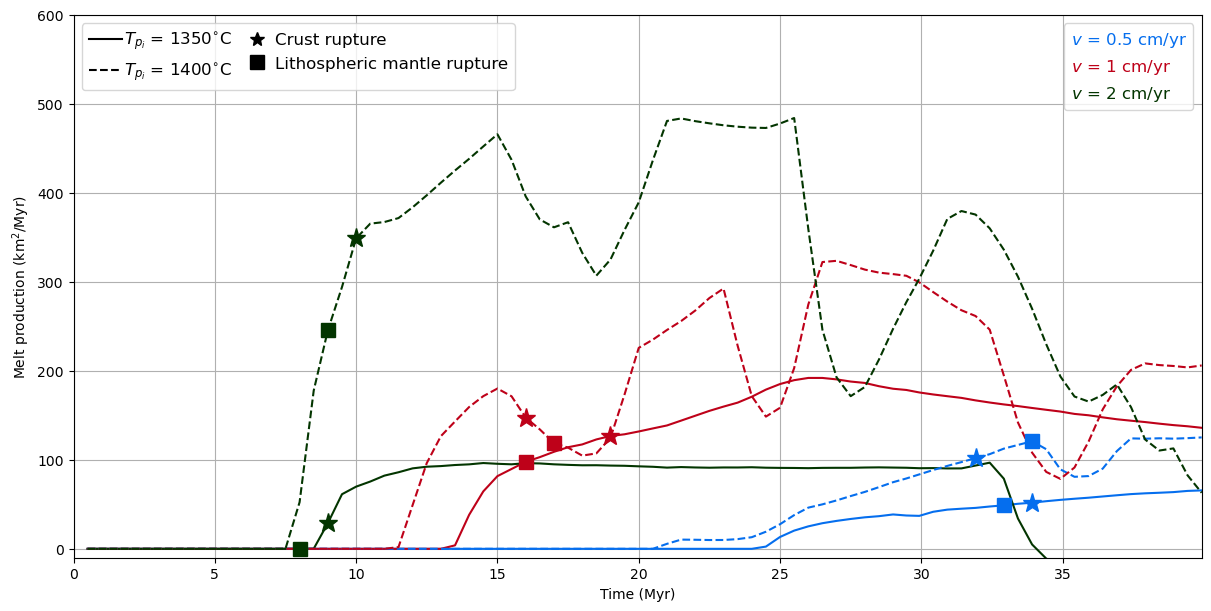

In [4]:
plt.close()
fig, axs = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

axs.plot(time[1:], Tp1350_v05_Phi_rate_evol, '-', color = 'xkcd:cerulean blue')
axs.plot(time[1:], Tp1350_v1_Phi_rate_evol, '-', color = 'xkcd:scarlet')
axs.plot(time[1:], Tp1350_v2_Phi_rate_evol, '-', color = 'xkcd:dark green')

axs.plot(time[1:], Tp1400_v05_Phi_rate_evol, '--', color = 'xkcd:cerulean blue')
axs.plot(time[1:], Tp1400_v1_Phi_rate_evol, '--', color = 'xkcd:scarlet')
axs.plot(time[1:], Tp1400_v2_Phi_rate_evol, '--', color = 'xkcd:dark green')

if(Hlit==80):
    #v = 0.5 cm/yr Tp = 1350
    crust_rupture_v05_Tp1350 = 39.0 #Myr
    mantle_rupture_v05_Tp1350 = 21.0 #Myr

    #v = 1 cm/yr Tp = 1350
    crust_rupture_v1_Tp1350 = 20.0 #Myr
    mantle_rupture_v1_Tp1350 = 10.0 #Myr

    #v2 cm/yr Tp = 1350
    crust_rupture_v2_Tp1350 = 9.0 #Myr
    mantle_rupture_v2_Tp1350 = 5.0 #Myr

    #v = 0.5 cm/yr Tp = 1400
    crust_rupture_v05_Tp1400 = 36.0
    mantle_rupture_v05_Tp1400 = 20.0

    #v = 1 cm/yr Tp = 1400
    crust_rupture_v1_Tp1400 = 20.0
    mantle_rupture_v1_Tp1400 = 10.0

    #v2 cm/yr Tp = 1400
    crust_rupture_v2_Tp1400 = 9.0
    mantle_rupture_v2_Tp1400 = 5.0

elif(Hlit==120):
     #v = 0.5 cm/yr Tp = 1350
    crust_rupture_v05_Tp1350 = 34.0 #Myr
    mantle_rupture_v05_Tp1350 = 33.0 #Myr

    #v = 1 cm/yr Tp = 1350
    crust_rupture_v1_Tp1350 = 19.0 #Myr
    mantle_rupture_v1_Tp1350 = 16.0 #Myr

    #v2 cm/yr Tp = 1350
    crust_rupture_v2_Tp1350 = 9.0 #Myr
    mantle_rupture_v2_Tp1350 = 8.0 #Myr

    #v = 0.5 cm/yr Tp = 1400
    crust_rupture_v05_Tp1400 = 32.0
    mantle_rupture_v05_Tp1400 = 34.0

    #v = 1 cm/yr Tp = 1400
    crust_rupture_v1_Tp1400 = 16.0
    mantle_rupture_v1_Tp1400 = 17.0

    #v2 cm/yr Tp = 1400
    crust_rupture_v2_Tp1400 = 10.0
    mantle_rupture_v2_Tp1400 = 9.0

plot_rupture_time(axs, time, Tp1350_v05_Phi_rate_evol, crust_rupture_v05_Tp1350, mantle_rupture_v05_Tp1350, color = 'xkcd:cerulean blue')
plot_rupture_time(axs, time, Tp1350_v1_Phi_rate_evol, crust_rupture_v1_Tp1350, mantle_rupture_v1_Tp1350, color = 'xkcd:scarlet')
plot_rupture_time(axs, time, Tp1350_v2_Phi_rate_evol, crust_rupture_v2_Tp1350, mantle_rupture_v2_Tp1350, color = 'xkcd:dark green')

plot_rupture_time(axs, time, Tp1400_v05_Phi_rate_evol, crust_rupture_v05_Tp1400, mantle_rupture_v05_Tp1400, color = 'xkcd:cerulean blue')
plot_rupture_time(axs, time, Tp1400_v1_Phi_rate_evol, crust_rupture_v1_Tp1400, mantle_rupture_v1_Tp1400, color = 'xkcd:scarlet')
plot_rupture_time(axs, time, Tp1400_v2_Phi_rate_evol, crust_rupture_v2_Tp1400, mantle_rupture_v2_Tp1400, color = 'xkcd:dark green')


ylim=600
axs.set_xlim(0, time[-1])
axs.set_ylim(-10, ylim)
axs.set_xlabel('Time (Myr)')
axs.set_ylabel(r'Melt production (km$^2$/Myr)')

axs_aux = axs.twinx()
axs_aux.axis('off')

axs_aux.plot([-20, -20], [-20, -20], '-', color = 'xkcd:black', label=r'$T_{p_i}$ = 1350$^{\circ}$C')
axs_aux.plot([-20, -20], [-20, -20], '--', color = 'xkcd:black', label=r'$T_{p_i}$ = 1400$^{\circ}$C')

axs_aux.plot(-20, -20, '*', color = 'xkcd:black', markersize=10, label='Crust rupture')
axs_aux.plot(-20, -20, 's', color = 'xkcd:black', markersize=10, label='Lithospheric mantle rupture')

colors = ['xkcd:cerulean blue', 'xkcd:scarlet', 'xkcd:dark green'] #colors for the legend
axs.plot([-20, -20], [-20, -20], '-', color = colors[0], label=r'$v$ = 0.5 cm/yr')
axs.plot([-20, -20], [-20, -20], '-', color = colors[1], label=r'$v$ = 1 cm/yr')
axs.plot([-20, -20], [-20, -20], '-', color = colors[2], label=r'$v$ = 2 cm/yr')

fsize = 12
axs.legend(loc='upper right', labelcolor=colors, handlelength=0, handletextpad=0, fontsize=fsize)
axs_aux.legend(loc='upper left', fontsize=fsize, ncol=2, columnspacing=0.5, handletextpad=0.1)
axs.grid()

if(Hlit==120):
    figname = f'Melt_production_evolution_comparison_hlit120km'
elif(Hlit==80):
    figname = f'Melt_production_evolution_comparison_hlit80km'

print(figname)
plt.savefig(f'out/plots/{figname}.pdf', dpi=300)
plt.savefig(f'out/plots/{figname}.png', dpi=300)
